In [1]:
from google.colab import drive
drive.mount ('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q -U keras-tuner


     |████████████████████████████████| 71kB 5.7MB/s 


In [3]:
# Import required packages, libraries and classes for the project

import numpy as np
np.random.seed(1)

import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers.core import Dense
from keras.layers.recurrent import LSTM
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import datetime as dt
import time
from keras.layers import InputLayer, ConvLSTM2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.optimizers import Adam, SGD, Nadam
import keras
import kerastuner as kt
plt.style.use('default')

### Data Preprocessing

In [4]:
# Load the Dataset
df = pd.read_csv("/content/drive/My Drive/stockRAKPROP.csv",parse_dates = True,index_col=0)
df.head()

,Open,High,Low,Volume,SMA,EMA,MOM,RSI,ROC,MACD,BB,CHAIKIN,STOCH,STOCHD,Close
Date,,,,,,,,,,,,,,,
2014-06-15,1.10,1.11,1.06,13250000.0,0.990952,1.008244,0.17,54.520264,-1.851852,0.009229,0.9890,-3.163401e+07,86.111111,88.299663,1.06
2014-06-16,1.07,1.07,1.02,17000000.0,0.991905,1.003068,0.20,52.260883,-6.363636,0.005551,0.9875,-3.013509e+07,84.848485,90.909091,1.03
2014-06-17,1.02,1.06,1.02,14770000.0,0.995238,1.000375,0.22,54.856310,-5.357143,0.003829,0.9900,-3.007993e+07,93.939394,93.939394,1.06
2014-06-18,1.06,1.07,1.04,6800000.0,0.998095,0.994413,0.10,54.856310,-4.504505,-0.001478,0.9920,-3.370621e+07,93.939394,92.929293,1.06
2014-06-19,1.06,1.08,1.06,19480000.0,1.000476,0.987854,0.05,54.856310,6.000000,-0.008231,0.9950,-3.462068e+07,93.939394,87.422613,1.06


In [5]:
# Correlation Matrix
df.corr()['Close']

Open       0.995513
High       0.997637
Low        0.997192
Volume     0.317317
SMA        0.974454
EMA        0.981913
MOM        0.184567
RSI        0.228810
ROC        0.185943
MACD       0.329849
BB         0.975488
CHAIKIN   -0.424417
STOCH      0.088506
STOCHD     0.086778
Close      1.000000
Name: Close, dtype: float64

In [6]:
df.columns

Index(['Open', 'High', 'Low', 'Volume', 'SMA', 'EMA', 'MOM', 'RSI', 'ROC',
       'MACD', 'BB', 'CHAIKIN', 'STOCH', 'STOCHD', 'Close'],
      dtype='object')

In [7]:
# Extracting the features for the ConvLSTM model
series = df[["Close",	"MOM",	"RSI",	"ROC",	"MACD",	"BB",	"CHAIKIN",	"STOCH"]]
print(series.shape)
series.head()

(1467, 8)


,Close,MOM,RSI,ROC,MACD,BB,CHAIKIN,STOCH
Date,,,,,,,,
2014-06-15,1.06,0.17,54.520264,-1.851852,0.009229,0.9890,-3.163401e+07,86.111111
2014-06-16,1.03,0.20,52.260883,-6.363636,0.005551,0.9875,-3.013509e+07,84.848485
2014-06-17,1.06,0.22,54.856310,-5.357143,0.003829,0.9900,-3.007993e+07,93.939394
2014-06-18,1.06,0.10,54.856310,-4.504505,-0.001478,0.9920,-3.370621e+07,93.939394
2014-06-19,1.06,0.05,54.856310,6.000000,-0.008231,0.9950,-3.462068e+07,93.939394


In [8]:
# Normalisation
sc_X = StandardScaler()
series.iloc[:,1:] = sc_X.fit_transform(series.iloc[:,1:])
sc_y = StandardScaler()
series[['Close']] = sc_y.fit_transform(series[['Close']])
series

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

,Close,MOM,RSI,ROC,MACD,BB,CHAIKIN,STOCH
Date,,,,,,,,
2014-06-15,2.854058,3.737399,0.281264,-0.409551,0.454591,2.476301,-1.835892,1.067338
2014-06-16,2.657587,4.415003,0.014683,-0.898457,0.181178,2.466235,-1.703946,1.026178
2014-06-17,2.854058,4.866739,0.320913,-0.789391,0.053229,2.483011,-1.699090,1.322527
2014-06-18,2.854058,2.156323,0.320913,-0.696998,-0.341246,2.496432,-2.018303,1.322527
2014-06-19,2.854058,1.026983,0.320913,0.441289,-0.843141,2.516563,-2.098802,1.322527
...,...,...,...,...,...,...,...,...
2020-05-05,-1.795765,-0.170117,-0.134290,-0.391514,-0.191906,-1.850583,0.650931,-0.290927
2020-05-06,-1.821961,-0.124943,-0.398894,-0.332723,-0.208115,-1.847228,0.665667,-0.109825
2020-05-07,-1.841608,-0.079770,-0.603226,-0.575175,-0.202471,-1.843873,0.653563,-0.159217


In [9]:
# Train/Test Data Split
train_start = dt.date(2014,5,15)
train_end = dt.date(2020,3,1)
train_data = series.loc[train_start:train_end]

test_start = dt.date(2020,3,2)
test_end = dt.date(2020,6,14)
test_data = series.loc[test_start:test_end]

print(train_data.shape,test_data.shape)

(1416, 8) (51, 8)


In [10]:
train = train_data.values
val = test_data.values

In [11]:
# Setting up an Early Stopping function
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')
callbacks_list = [earlystop]
RMSE = keras.metrics.RootMeanSquaredError()

In [12]:
X_train = []
Y_train = []
X_val = []
Y_val = []
timesteps = 45

# Loop for training data
for i in range(timesteps,train.shape[0]):
  X_train.append(train[i-timesteps:i])
  Y_train.append(train[i][0])
X_train,Y_train = np.array(X_train),np.array(Y_train)

# Loop for val data
for i in range(timesteps,val.shape[0]):
  X_val.append(val[i-timesteps:i])
  Y_val.append(val[i][0])
X_val,Y_val = np.array(X_val),np.array(Y_val)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1, X_train.shape[2], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1, X_val.shape[2], 1)

In [13]:
from keras import backend as K
from keras.losses import mean_squared_error

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(mean_squared_error(y_true, y_pred))

In [14]:
def model_builder(hp):
  # Define the ConvLSTM Model
  model = Sequential()

  # Input shape: (samples, time, channels, rows, cols) see: https://keras.io/layers/recurrent/#convlstm2d
  hp_filter = hp.Choice('filter', values = [8,16,32])
  model.add(ConvLSTM2D(
          filters=hp_filter,
          kernel_size=(10, 10),
          input_shape=(X_train.shape[1], 1, X_train.shape[3], 1),
          padding='same',
          return_sequences=True))
  model.add(LeakyReLU())
  model.add(BatchNormalization())

  model.add(ConvLSTM2D(
          filters=hp_filter,
          kernel_size=(5, 5),
          padding='same',
          return_sequences=False))
  model.add(LeakyReLU())
  model.add(BatchNormalization())
  hp_dropout = hp.Float('dropout', min_value = .2, max_value = .5, step = .1)

  model.add(Dropout(rate = hp_dropout))

  model.add(Flatten())

  hp_units = hp.Int('units', min_value = 16, max_value = 64, step = 8)
  model.add(Dense(units=hp_units, kernel_initializer='TruncatedNormal'))
  model.add(LeakyReLU())
  model.add(Dropout(rate = hp_dropout))

  model.add(Dense(units=hp_units, kernel_initializer='TruncatedNormal'))
  model.add(LeakyReLU())
  model.add(Dropout(rate = hp_dropout))

  model.add(Dense(1))
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 
  hp_batch = hp.Choice('batch_size', values = [8,16,64])

  model.compile(optimizer = optimizers.Adam(learning_rate = hp_learning_rate),
                loss = root_mean_squared_error,
                metrics=[root_mean_squared_error,'mse', 'mae', 'mape'])
  
  return model

In [15]:
tuner = kt.Hyperband(model_builder,
                     objective = 'val_loss', 
                     max_epochs = 50,
                     factor = 3,
                     directory = 'my_dir',
                     project_name = 'intro_to_kt')

In [16]:
import tensorflow as tf
import IPython
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

In [17]:
tuner.search(X_train, Y_train, epochs = 10, validation_data = (X_val, Y_val), callbacks = [ClearTrainingOutput()])


Trial 90 Complete [00h 16m 02s]
val_loss: 0.16510069370269775

Best val_loss So Far: 0.07214578241109848
Total elapsed time: 05h 08m 02s
INFO:tensorflow:Oracle triggered exit


In [18]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete.\nThe optimal number of units in the first densely-connected layer is {best_hps.get('units')}\n
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}\n
The best dropout is {best_hps.get('dropout')}\n
The best batch size is {best_hps.get('batch_size')}\n
The best num of epochs is {best_hps.get('tuner/epochs')}\n
The best num of filters is {best_hps.get('filter')}.
""")


The hyperparameter search is complete.
The optimal number of units in the first densely-connected layer is 64

The optimal learning rate for the optimizer is 0.001

The best dropout is 0.30000000000000004

The best batch size is 16

The best num of epochs is 50

The best num of filters is 16.



In [19]:
tuner.results_summary(num_trials=90)

Results summary
Results in my_dir/intro_to_kt
Showing 90 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
filter: 16
dropout: 0.30000000000000004
units: 64
learning_rate: 0.001
batch_size: 16
tuner/epochs: 50
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.07214578241109848
Trial summary
Hyperparameters:
filter: 32
dropout: 0.2
units: 32
learning_rate: 0.01
batch_size: 64
tuner/epochs: 50
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.08999530225992203
Trial summary
Hyperparameters:
filter: 8
dropout: 0.2
units: 24
learning_rate: 0.01
batch_size: 64
tuner/epochs: 50
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.16510069370269775
Trial summary
Hyperparameters:
filter: 8
dropout: 0.5000000000000001
units: 56
learning_rate: 0.01
batch_size: 64
tuner/epochs: 17
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.17939986288547516
Trial summary
Hyperparameters:
filter: 32
dropout: 0.2
units:

In [20]:
model = tuner.hypermodel.build(best_hps)
model.fit(X_train, Y_train, epochs = 50, validation_data = (X_val, Y_val))

Epoch 1/50
43/43 [==============================] - 23s 454ms/step - loss: 0.3329 - root_mean_squared_error: 0.3329 - mse: 0.2388 - mae: 0.3329 - mape: 94.3887 - val_loss: 1.7756 - val_root_mean_squared_error: 1.7756 - val_mse: 3.1537 - val_mae: 1.7756 - val_mape: 98.2770
Epoch 2/50
43/43 [==============================] - 19s 443ms/step - loss: 0.2150 - root_mean_squared_error: 0.2150 - mse: 0.0832 - mae: 0.2150 - mape: 81.4185 - val_loss: 1.7839 - val_root_mean_squared_error: 1.7839 - val_mse: 3.1834 - val_mae: 1.7839 - val_mape: 98.7387
Epoch 3/50
43/43 [==============================] - 20s 457ms/step - loss: 0.1880 - root_mean_squared_error: 0.1880 - mse: 0.0720 - mae: 0.1880 - mape: 58.5105 - val_loss: 1.7659 - val_root_mean_squared_error: 1.7659 - val_mse: 3.1194 - val_mae: 1.7659 - val_mape: 97.7401
Epoch 4/50
43/43 [==============================] - 19s 447ms/step - loss: 0.1789 - root_mean_squared_error: 0.1789 - mse: 0.0648 - mae: 0.1789 - mape: 53.7128 - val_loss: 1.7589 - 

In [21]:
# Plotting the predictions
def plot_data(Y_test,Y_hat):
    plt.plot(Y_test,c = 'r')
    plt.plot(Y_hat,c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Close')
    plt.title('Prediction Graph using Multivariate-LSTM model')
    plt.legend(['Actual','Predicted'],loc = 'lower right')
    plt.show()

In [22]:
# Plotting the training errors
def plot_loss(train_loss,val_loss):
    plt.plot(train_loss,c = 'r')
    plt.plot(val_loss,c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['train','val'],loc = 'upper right')
    plt.show()

In [23]:
# Evaluating the model
def evaluate_model(model,X_val):
     # Prediction Time 
    Y_hat = model.predict(X_val)
    return Y_val, Y_hat
  

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 45, 1, 8, 16)      108864    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 45, 1, 8, 16)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 45, 1, 8, 16)      64        
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 1, 8, 16)          51264     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 1, 8, 16)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 8, 16)          64        
_________________________________________________________________
dropout (Dropout)            (None, 1, 8, 16)          0

In [25]:
y_pred = model.predict(X_val)
y_true = np.array([Y_val]).T

mae = tf.keras.losses.MeanAbsoluteError()
mae = mae(y_true, y_pred).numpy()

mape = tf.keras.losses.MeanAbsolutePercentageError()
mape = mape(y_true, y_pred).numpy()

mse = tf.keras.losses.MeanSquaredError()
mse = mse(y_true, y_pred).numpy()

rmse = sqrt(mse)


In [26]:
print('MSE = {}'.format(round(mse, 5)))
print('RMSE = {}'.format(round(rmse, 5)))
print('MAPE = {}'.format(round(mape, 5)))
print('MAE = {}'.format(round(mae, 5)))

MSE = 0.14869999885559082
RMSE = 0.3856
MAPE = 21.252099990844727
MAE = 0.38440001010894775


In [27]:
true ,predicted = evaluate_model(model,X_val)

In [28]:
train_date = df['2014-05-15' : '2020-03-1'].index
test_date = df['2020-03-2' :].index
pred_date = df['2020-03-2' :].index[45:]

In [29]:
Y_train = sc_y.inverse_transform(np.array([train[:,0]]))
Y_test = sc_y.inverse_transform(np.array([val[:,0]]))
Y_pred = sc_y.inverse_transform(predicted.T)

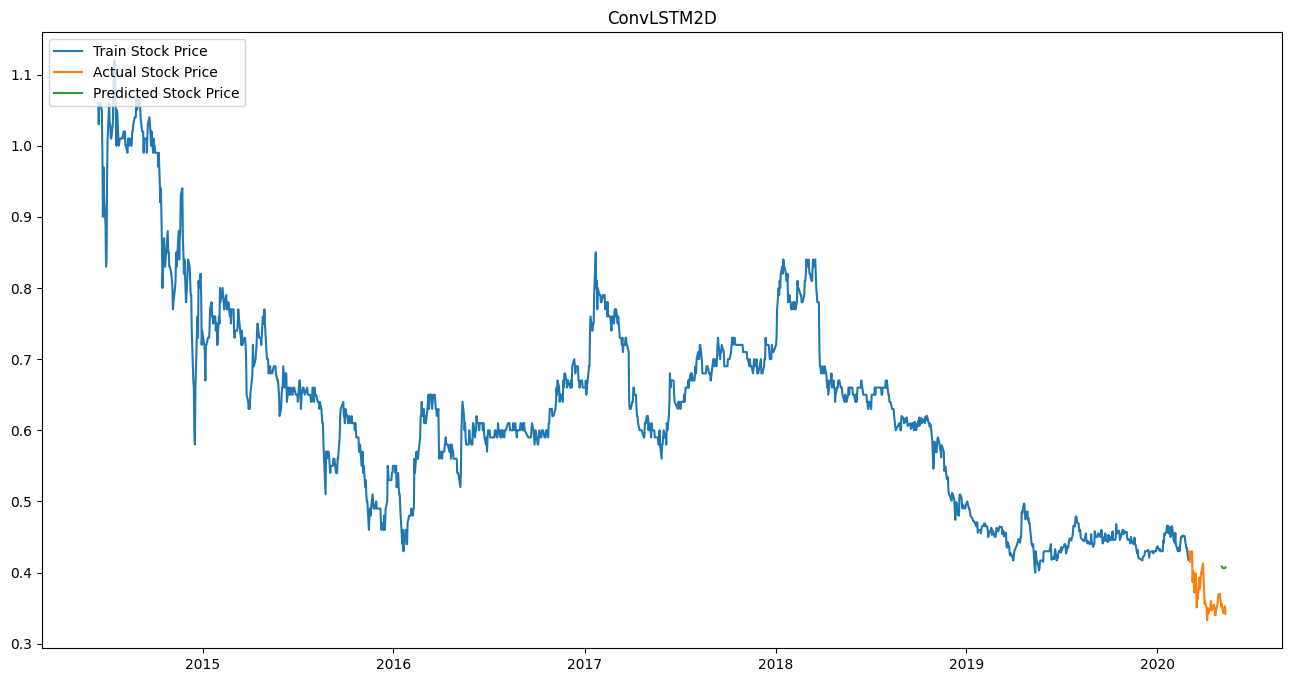

In [30]:
import pandas as pd
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from matplotlib import dates as mpl_dates

plt.figure(figsize=(16,8))
price_close_train = Y_train[0]
price_close_test = Y_test[0]
plt.plot(train_date, price_close_train, label = "Train Stock Price")
plt.plot(test_date, price_close_test, label = "Actual Stock Price")
plt.plot(pred_date, Y_pred[0], label = "Predicted Stock Price")

plt.title("ConvLSTM2D")
plt.legend(loc='upper left')
#plt.tight_layout()

plt.show()

In [31]:
# Save a model
model.save('ConvLSTM2D_dataset4.h5')